# Image compression

## Question 1

## JPEG Compression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import cv2

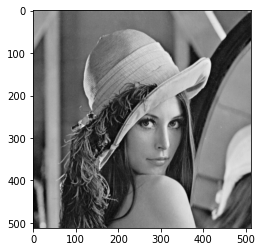

In [2]:
image = cv2.imread("lenna.tif",0)
plt.imshow(image,cmap='gray')
plt.show()

### Functions for JPEG Encoding and Decoding

In [3]:
def dct2(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

def jpg_compress(img, threshold = 0.015, block_size=8):
    dct = np.zeros(img.shape)

    for i in range(0,img.shape[0],8):
        for j in range(0,img.shape[1],8):
            dct[i:(i+8),j:(j+8)] = dct2( img[i:(i+8),j:(j+8)] )
            
    thresh = 0.015
    dct_thresh = dct * (np.abs(dct) > (thresh*np.max(dct)))
    percent_nonzeros = np.count_nonzero(dct_thresh) / (img.shape[0]*img.shape[1]*1.)
    print("Keeping only %f%% of the DCT coefficients" % (percent_nonzeros*100.0))
    
    return dct, dct_thresh
    

def jpg_decompress(dct):   
    dct_inv = np.zeros(dct.shape)

    for i in range(0,dct.shape[0],8):
        for j in range(0,dct.shape[1],8):
            dct_inv[i:(i+8),j:(j+8)] = idct2( dct[i:(i+8),j:(j+8)] )

      
    return dct_inv.astype('uint8')  

### Visualise compression 

Keeping only 5.049515% of the DCT coefficients


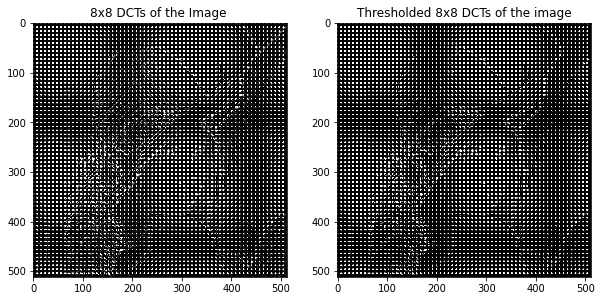

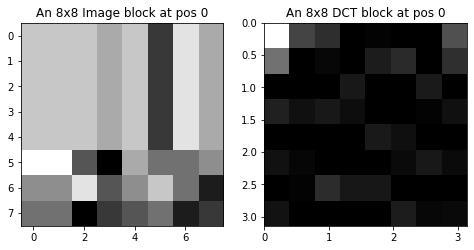

In [4]:
#imsize = im.shapei
img_dct, img_compressed = jpg_compress(image)

f, ax = plt.subplots(1, 2, figsize= (10,7))
ax[0].imshow(img_dct, cmap='gray', vmax = np.max(img_dct)*0.01,vmin = 0)
ax[0].set_title('8x8 DCTs of the Image ')
ax[1].imshow(img_compressed,cmap='gray',vmax = np.max(img_dct)*0.01,vmin = 0)
ax[1].set_title( "Thresholded 8x8 DCTs of the image")
plt.show()

pos = 0
f, ax = plt.subplots(1,2,figsize= (8,7) )
ax[0].imshow(image[pos:pos+8,pos:pos+8],cmap='gray')
ax[0].set_title( "An 8x8 Image block at pos "+str(pos))
ax[1].imshow(img_dct[pos:pos+8,pos:pos+8],cmap='gray',vmax= np.max(img_dct)*0.01,vmin = 0, extent=[0,np.pi,np.pi,0])
ax[1].set_title("An 8x8 DCT block at pos "+str(pos))
plt.show()

### Visualise Decompression

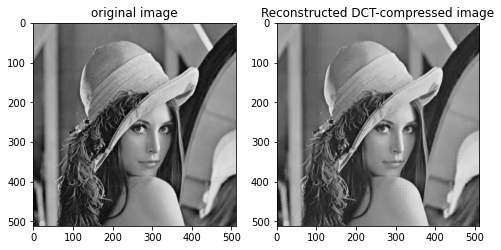

In [5]:
img_recon = jpg_decompress(img_compressed) 

#Compare DCT compressed image with original
f, ax = plt.subplots(1,2, figsize=((8,7)))
ax[0].imshow(image,cmap='gray')
ax[0].set_title("original image" )

ax[1].imshow(img_recon, cmap='gray')
ax[1].set_title("Reconstructed DCT-compressed image" )
plt.show()

### Compare with OpenCV conversions 

In [6]:
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

def rmse(img1, img2):
    return np.sqrt(np.mean((img1 - img2) ** 2))

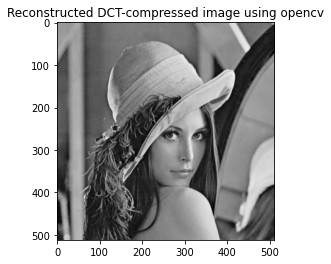

Metrics between original and reconstructed image using our functions:
RMSE =  4.766222906908556
PSNR =  34.567316616927826


Metrics between original and reconstructed image using OpenCV functions:
RMSE =  1.6464218182066213
PSNR =  43.79998135506467


Metrics between OpenCV reconstructed and our results:
RMSE =  4.843323522681644
PSNR =  34.427934011260064


In [7]:
result, img_comp_cv = cv2.imencode('.jpg', image)
img_recon_cv = cv2.imdecode(img_comp_cv, 0)
plt.imshow(img_recon_cv, cmap='gray')
plt.title('Reconstructed DCT-compressed image using opencv')
plt.show()

print('Metrics between original and reconstructed image using our functions:')
print('RMSE = ', rmse(image, img_recon))
print('PSNR = ', psnr(image, img_recon))

print('\n\nMetrics between original and reconstructed image using OpenCV functions:')
print('RMSE = ', rmse(image, img_recon_cv))
print('PSNR = ', psnr(image, img_recon_cv))

print('\n\nMetrics between OpenCV reconstructed and our results:')
print('RMSE = ', rmse(img_recon, img_recon_cv))
print('PSNR = ', psnr(img_recon, img_recon_cv))


## Q2. Improved Adaptive Huffman Coding

Adaptive Tree Constructed using Faller-Gallager-Knuth Algorithm

In [6]:
import numpy as np
import queue
import copy

# Node class
class Node():
    def __init__(self, char, number, left=None, right=None, parent = None):
        self.char = char  # The node character
        self.number = number # frequency
        self.left = left    # Left child
        self.right = right  # Right child
        self.parent = parent #parent
        
    def size(self):
        sizenumber = 1
        if self.left is not None:
            i = self.left.size()
            sizenumber += i
        if self.right is not None:
            i = self.right.size()
            sizenumber += i
        return sizenumber

    def height(self):
        leftH = 0
        rightH = 0
        if self.left is not None:
            leftH += 1
            leftH += self.left.height()
        if self.right is not None:
            rightH += 1
            rightH += self.right.height()
        if leftH > rightH:
            return leftH
        else:
            return rightH
        
    def printNode(self):
        print(self.char + " X " + str(self.number) + ";")


In [7]:
class AdaptiveTree:
    def __init__(self):
        self.zero_node = Node(char="zero", number = 0)   
        self.root = self.zero_node    #root
        self.nodes = [] #list of nodes in adaptive tree          
        
    def insert(self,char):
    
        #check the node exists
        new_node = None
        for node in self.nodes:
            if node.char == char:
                new_node = node
            
            
        #if new, insert 
        if new_node is None:
        
            new_node = Node(char=char, number=1)
            new_parent = Node(char=".../", number=1, left=self.zero_node, right=new_node, parent=self.zero_node.parent)
       
            new_node.parent = new_parent
            self.zero_node.parent = new_parent
            
            if new_parent.parent is None:
                self.root = new_parent
            else:
                new_parent.parent.left = new_parent
                
            self.nodes.insert(0,new_parent)
            self.nodes.insert(0,new_node)         
                
            new_node = new_parent.parent
        
        #update tree 
        while new_node is not None:
        
            #find next node 
            equivalent_node = self.find_equivalent_node_node(new_node.number)

            #if new_node not largest swap the nodes
            if (new_node is not equivalent_node and new_node is not equivalent_node.parent and equivalent_node is not new_node.parent):
                self.swap_nodes(new_node, equivalent_node)
            
         
            new_node.number = new_node.number + 1
            new_node = new_node.parent
       
   
    def find_equivalent_node_node(self, number):
        for node in reversed(self.nodes):
            if node.number == number:
                return node   
             
    #sawp two nodes from the AdaptiveTree
    def swap_nodes(self, node1, node2):
    
        #index of nodes
        index1 = self.nodes.index(node1)
        index2 = self.nodes.index(node2)
        
        self.nodes[index1], self.nodes[index2] = self.nodes[index2], self.nodes[index1]
        
        node1_prev_parent = node1.parent
        node1.parent = node2.parent
        node2.parent = node1_prev_parent

        
        if node1.parent.left is node2:
            node1.parent.left = node1
        else:
            node1.parent.right = node1

            
        if node2.parent.left is node1:
            node2.parent.left = node2
        else:
            node2.parent.right = node2



In [8]:
def printTree(node, level=0):
    if node != None:
        print(' ' * 4 * level + '->', node.char,"X", node.number)
        printTree(node.left, level + 1)
        printTree(node.right, level + 1)

# Function to Decode Huffman Codes
def decodeHuffman(node, code, prefix = ""):
    
    #check left children
    if (node.left != None):
        decodeHuffman(node.left, code, prefix + "0")
    #else leaf
    else:
        code[node.char] = prefix
        return
     
    #check right children
    if (node.right != None):
        decodeHuffman(node.right, code, prefix + "1")
    #else leaf
    else:
        code[node.char] = prefix
        return
    
    return code

# Function to Construct Tree
def const_tree(root,  nodeNumber):
    if len(root.char) > 5:
        s = root.char[0:4] + "..." + " X " + str(root.number)
        msg = "Node " + str(nodeNumber) + "\n" + s
        print(msg)
    else:
        msg = "Node " + str(nodeNumber) + "\n" + root.char + " X " + str(root.number)  
        print(msg)

    nodeNumber += 1
    if root.left is not None:
        const_tree(root.left,nodeNumber)
        nodeNumber += root.left.size()
    if root.right is not None:
        const_tree(root.right, nodeNumber)
        nodeNumber += root.right.size()

# Adaptive Huffman Coding function        
def buildAdaptiveTree(s):
    global TREE#global variable to save last input
    i = 0
    
    # Adaptive tree, using FGK algorithm
    TREE = AdaptiveTree()
    #encode each character one by one
    for char in s:
        print("Step ",i)
        TREE.insert(char)
        rootNode = TREE.nodes[-1]
        printTree(rootNode)
        i = i+1

    #getting root node
    rootNode = TREE.nodes[-1]
    nodeNumber = 1

#     const_tree(rootNode, nodeNumber)#draw tree
    code = {}#where to store codes
    codes = decodeHuffman(rootNode, code)#get codes for each letter
    return codes



### Steps of Constructing Adaptive Huffman Tree

In [9]:
string = "caaadbddda"
codes = buildAdaptiveTree(string)

Step  0
-> .../ X 1
    -> zero X 0
    -> c X 1
Step  1
-> .../ X 2
    -> .../ X 1
        -> zero X 0
        -> a X 1
    -> c X 1
Step  2
-> .../ X 3
    -> .../ X 1
        -> zero X 0
        -> c X 1
    -> a X 2
Step  3
-> .../ X 4
    -> .../ X 1
        -> zero X 0
        -> c X 1
    -> a X 3
Step  4
-> .../ X 5
    -> .../ X 2
        -> .../ X 1
            -> zero X 0
            -> d X 1
        -> c X 1
    -> a X 3
Step  5
-> .../ X 6
    -> .../ X 3
        -> c X 1
        -> .../ X 2
            -> .../ X 1
                -> zero X 0
                -> b X 1
            -> d X 1
    -> a X 3
Step  6
-> .../ X 7
    -> a X 3
    -> .../ X 4
        -> d X 2
        -> .../ X 2
            -> .../ X 1
                -> zero X 0
                -> b X 1
            -> c X 1
Step  7
-> .../ X 8
    -> a X 3
    -> .../ X 5
        -> .../ X 2
            -> .../ X 1
                -> zero X 0
                -> b X 1
            -> c X 1
        -> d X 3
Step  8
->

### Encoding and Decoding

In [10]:
encoding = ""
for s in string:
    encoding  = encoding + codes[s]

print("Message is : ", string)
print("Encoding of message is :", encoding)
print("Length of Encoding is : ", len(encoding))
print("Codes are :",codes)
keys=list(codes.keys())  #in python 3, you'll need `list(i.keys())`
values=list(codes.values())

temp=""
decode = ""
for i in range(len(encoding)):
    temp = temp + encoding[i]
    if(temp in values):
        decode = decode +(keys[values.index(temp)])
        temp=""
        
print("Decoded Meassage is : ", decode)    

Message is :  caaadbddda
Encoding of message is : 1011111110100100011
Length of Encoding is :  19
Codes are : {'d': '0', 'zero': '1000', 'b': '1001', 'c': '101', 'a': '11'}
Decoded Meassage is :  caaadbddda


# Question 3: Modified BTC for natural image compression

Write python code from scratch for Modified BTC for natural image compression   explained by author in research paper 2 (barba.png) and demonstrate results of each step. Also compare the results with original BTC algorithm in terms of RMSE and PSNR (dB).

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2

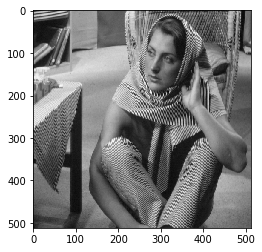

In [2]:
img = plt.imread('barba.png',0)
plt.imshow(img, cmap = 'gray')
plt.show()

## PSNR and RMSE calculation

In [3]:
def PSNR(img, noisy):
    max_pixel = 255.0
    MSE = np.mean((img - noisy) ** 2)
    RMSE = np.sqrt(MSE)
    if MSE == 0:
        PSNR = 100
    else:
        PSNR = 20 * np.log10( (max_pixel) / RMSE)
    return RMSE, PSNR    

## Classical Block Truncation Coding

In [4]:
def btc_block_classical(img_block):
    m = img_block.shape[0] * img_block.shape[1]
    mean = np.mean(img_block)
    sigma = np.std(img_block)
    q = img_block[img_block > mean].shape[0]
    a = round( mean - sigma * np.sqrt( q / (m - q)) )
    b = round( mean + sigma * np.sqrt( (m - q) / q) )
    output = np.copy(img_block)
    bitmap = np.zeros(output.shape)
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            if output[i,j] > mean:
                bitmap[i,j] = 1
                output[i,j] = b
            else:
                bitmap[i,j] = 0
                output[i,j] = a
    return bitmap, output      

## Non Parametric Search 

### BTC based on Minimum mean square error

In [5]:
def btc_block_JMSE(img_block):
    """
        This function compresses using Minimum mean square error criterion
    """
    m = img_block.shape[0] * img_block.shape[1]
    mean = np.mean(img_block)
    sigma = np.std(img_block)
    Y = np.sort(img_block.ravel())
    min_JMSE = 1e4
    a_optim = 0
    b_optim = 0
    for Xth in np.unique(Y):
        q = img_block[img_block > Xth].shape[0]
        if q!=0:
            a = np.mean(Y[0:m-q])
            b = np.mean(Y[m-q:m])
            JMSE = np.sum( (Y[0:m-q] - a) ** 2) + np.sum( (Y[m-q:m] - b) **2 )
            if min_JMSE > JMSE:
                a_optim, b_optim = a, b
    a, b = round(a_optim), round(b_optim)        
    output = np.copy(img_block)
    bitmap = np.zeros(output.shape)
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            if output[i,j] > mean:
                bitmap[i,j] = 1
                output[i,j] = b
            else:
                bitmap[i,j] = 0
                output[i,j] = a
    return bitmap, output      

### BTC based on Minimum absolute error

In [6]:
def btc_block_JAE(img_block):
    """
        This function compresses using Minimum mean absolute error criterion.
    """
    m = img_block.shape[0] * img_block.shape[1]
    mean = np.mean(img_block)
    sigma = np.std(img_block)
    Y = np.sort(img_block.ravel())
    min_JMSE = 1e4
    a_optim = 0
    b_optim = 0
    for Xth in np.unique(Y):
        q = img_block[img_block > Xth].shape[0]
        if q!=0:
            a = np.median(Y[0:m-q])
            b = np.median(Y[m-q:m])
            JMSE = np.sum( (Y[0:m-q] - a)) + np.sum( (Y[m-q:m] - b))
            if min_JMSE > JMSE:
                a_optim, b_optim = a, b
    output = np.copy(img_block)
    bitmap = np.zeros(output.shape)
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            if output[i,j] > mean:
                bitmap[i,j] = 1
                output[i,j] = b_optim
            else:
                bitmap[i,j] = 0
                output[i,j] = a_optim
    return bitmap, output      

## Modified BTC (Paper 2)

In [7]:
def btc_block_modified(img_block):
    m = img_block.shape[0] * img_block.shape[1]
    mean = np.mean(img_block)
    sigma = np.std(img_block)
    X_3 = np.mean(img_block**3)
    X_2 = np.mean(img_block**2)
    
    A = ( (3 * mean * X_2) - X_3 *2* (mean)**3 ) / sigma**3
    
    q =  m /2 * (1 + (A * np.sqrt(1.0 / (A**2 + 4))) )
    
    a = round( mean - sigma * np.sqrt( q / (m - q  + 1e-10)) )
    b = round( mean + sigma * np.sqrt( (m - q) / (q + 1e-10) ))
    output = np.copy(img_block)
    bitmap = np.zeros(output.shape)
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            if output[i,j] > mean:
                bitmap[i,j] = 1
                output[i,j] = b
            else:
                bitmap[i,j] = 0
                output[i,j] = a
    return bitmap, output      

In [8]:
def btc_image(img, block_size, algo = "JMSE"):
    bitmap = np.zeros(img.shape)
    output = np.zeros(img.shape)
    if algo == "classical":
        for i in range(0, img.shape[0], block_size):
            for j in range(0, img.shape[1], block_size):
                img_block = img[i: i + block_size, j:j + block_size]
                bitmap[i: i + block_size, j:j + block_size], output[i: i + block_size, j:j + block_size] = btc_block_classical(img_block)
        
    elif  algo == "JMSE":
        for i in range(0, img.shape[0], block_size):
            for j in range(0, img.shape[1], block_size):
                img_block = img[i: i + block_size, j:j + block_size]
                bitmap[i: i + block_size, j:j + block_size], output[i: i + block_size, j:j + block_size] = btc_block_JMSE(img_block)
    elif algo == "JAE":
        for i in range(0, img.shape[0], block_size):
            for j in range(0, img.shape[1], block_size):
                img_block = img[i: i + block_size, j:j + block_size]
                bitmap[i: i + block_size, j:j + block_size], output[i: i + block_size, j:j + block_size] = btc_block_JAE(img_block)
    elif algo == "modified":
        for i in range(0, img.shape[0], block_size):
            for j in range(0, img.shape[1], block_size):
                img_block = img[i: i + block_size, j:j + block_size]
                bitmap[i: i + block_size, j:j + block_size], output[i: i + block_size, j:j + block_size] = btc_block_modified(img_block)

    return bitmap, output

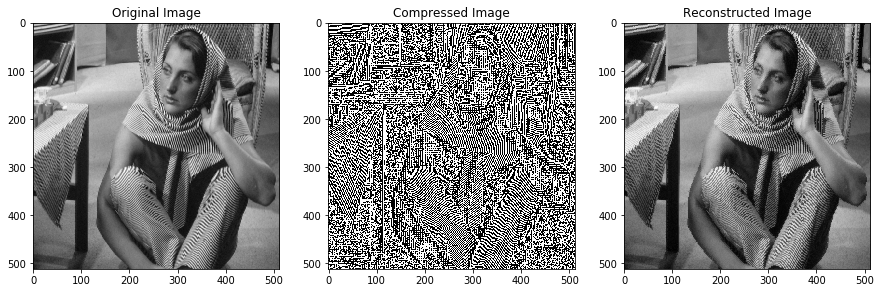

RMSE: 8.48171961137115
PSNR (dB): 29.561125379539483


In [9]:
compressed, recon = btc_image(img,4, "classical")

f, ax = plt.subplots(1,3,figsize = (15,8))

ax[0].imshow(img, cmap = "gray")
ax[0].set_title("Original Image")
ax[1].imshow(compressed, cmap = "gray")
ax[1].set_title("Compressed Image")
ax[2].imshow(recon, cmap = "gray")
ax[2].set_title("Reconstructed Image")
plt.show()

RMSE_c, PSNR_c = PSNR(img, recon)
print(f"RMSE: {RMSE_c}\nPSNR (dB): {PSNR_c}")

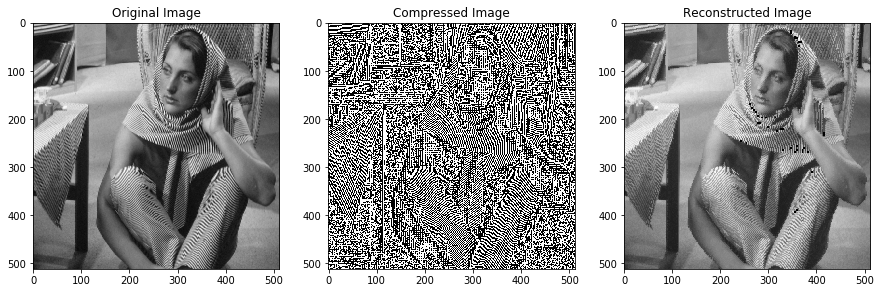

RMSE: 14.43325082580618
PSNR (dB): 24.943520428660257


In [10]:
compressed, recon = btc_image(img, 4, "JMSE")

f, ax = plt.subplots(1,3,figsize = (15,8))

ax[0].imshow(img, cmap = "gray")
ax[0].set_title("Original Image")
ax[1].imshow(compressed, cmap = "gray")
ax[1].set_title("Compressed Image")
ax[2].imshow(recon, cmap = "gray")
ax[2].set_title("Reconstructed Image")
plt.show()

RMSE_MSE, PSNR_MSE = PSNR(img, recon)
print(f"RMSE: {RMSE_MSE}\nPSNR (dB): {PSNR_MSE}")

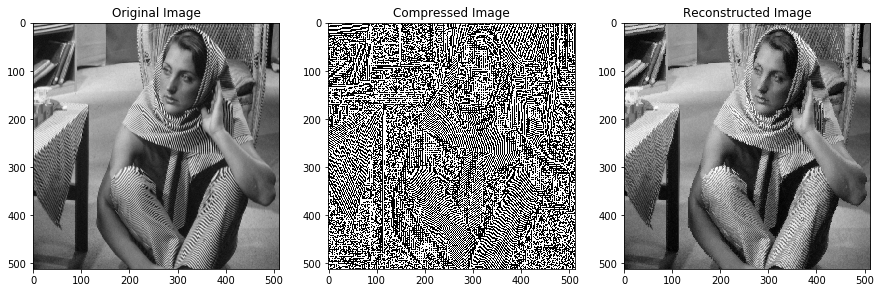

RMSE: 15.257878379074047
PSNR (dB): 24.460920632657263


In [11]:
compressed, recon = btc_image(img,4, "JAE")

f, ax = plt.subplots(1,3,figsize = (15,8))

ax[0].imshow(img, cmap = "gray")
ax[0].set_title("Original Image")
ax[1].imshow(compressed, cmap = "gray")
ax[1].set_title("Compressed Image")
ax[2].imshow(recon, cmap = "gray")
ax[2].set_title("Reconstructed Image")
plt.show()

RMSE_MAE, PSNR_MAE = PSNR(img, recon)
print(f"RMSE: {RMSE_MAE}\nPSNR (dB): {PSNR_MAE}")

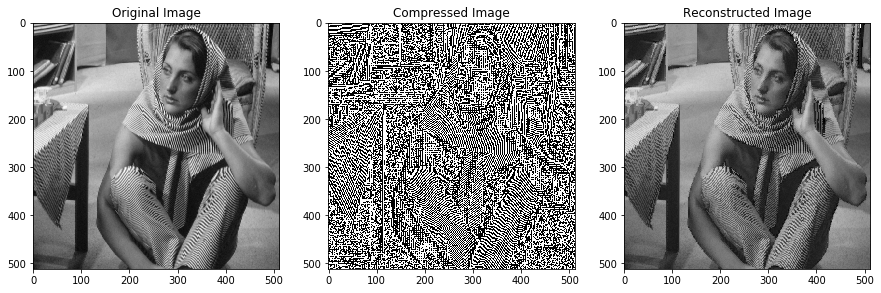

RMSE: 12.967168284097554
PSNR (dB): 25.873900668123344


In [12]:
compressed, recon = btc_image(img, 4, "modified")

f, ax = plt.subplots(1,3,figsize = (15,8))

ax[0].imshow(img, cmap = "gray")
ax[0].set_title("Original Image")
ax[1].imshow(compressed, cmap = "gray")
ax[1].set_title("Compressed Image")
ax[2].imshow(recon, cmap = "gray")
ax[2].set_title("Reconstructed Image")
plt.show()

RMSE_mod, PSNR_mod = PSNR(img, recon)
print(f"RMSE: {RMSE_mod}\nPSNR (dB): {PSNR_mod}")

# Comparison

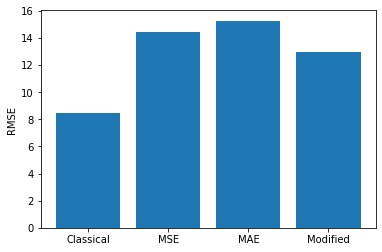

In [13]:
plt.bar(['Classical', 'MSE', 'MAE', 'Modified'],[RMSE_c,RMSE_MSE , RMSE_MAE, RMSE_mod])
plt.ylabel('RMSE')
plt.show()

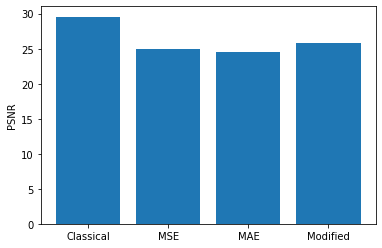

In [14]:
plt.bar(['Classical', 'MSE', 'MAE', 'Modified'],[PSNR_c,PSNR_MSE, PSNR_MAE, PSNR_mod])
plt.ylabel('PSNR')
plt.show()